In [1]:
import torch 
import torch.nn as nn 
import os 
from pprint import pprint
from src.device import select_device 
from src.testtrain import * 
from src.data import fetch_dataset, dataloader
from src.models.mlp import MLP 
from src.models.linear import Linear
from src.regularizers import * 
from src.metrics import * 
import matplotlib.pyplot as plt 


torch.manual_seed(0)

device = select_device()

training_data, test_data = fetch_dataset("MNIST", verbose=False)

train_dataloader, test_dataloader = dataloader(
    training_data, test_data, 
    batch_size=-1)

Epoch 1
-------------------------------
86.05653381347656
86.2850341796875
86.39756774902344
loss: 2.334753  [60000/60000]
Test Error: 
 Accuracy: 15.9%, Avg loss: 49.145477 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4682161211967468'


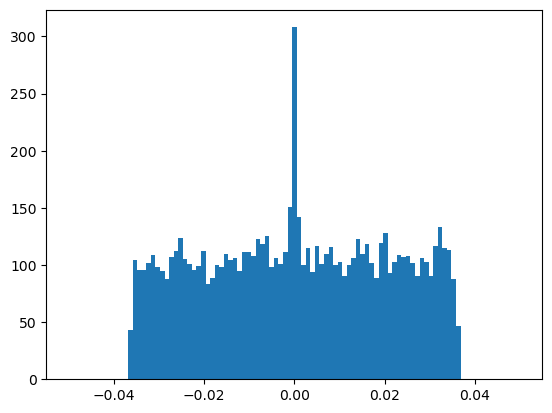

Epoch 2
-------------------------------
0.4003356099128723
loss: 2.320816  [60000/60000]
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.516500 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.46370023488998413'
Epoch 3
-------------------------------
0.4161381423473358
loss: 2.297004  [60000/60000]
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.478304 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.45969152450561523'
Epoch 4
-------------------------------
0.40304678678512573
loss: 2.263627  [60000/60000]
Test Error: 
 Accuracy: 20.6%, Avg loss: 2.432505 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.45634254813194275'
Epoch 5
-------------------------------
0.3918294310569763
loss: 2.222174  [60000/60000]
Test Error: 
 Accuracy: 23.0%, Avg loss: 2.381015 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4535020589828491'
Epoch 6
-------------------------------
0.4284302294254303
loss: 2.174530  [60000/60000]
Test Error: 
 Accuracy: 26.3%, Avg loss: 2.325088 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4500591456890106'
Epoch 7
---

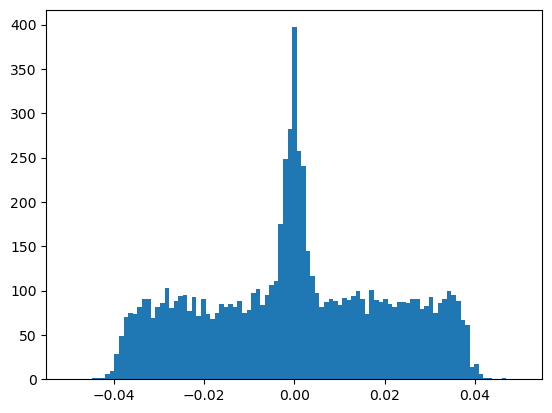

Epoch 11
-------------------------------
0.37202972173690796
loss: 1.894753  [60000/60000]
Test Error: 
 Accuracy: 45.4%, Avg loss: 2.024670 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4389170706272125'
Epoch 12
-------------------------------
0.36611899733543396
loss: 1.837489  [60000/60000]
Test Error: 
 Accuracy: 48.7%, Avg loss: 1.965894 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.43707913160324097'
Epoch 13
-------------------------------
0.3626510500907898
loss: 1.781217  [60000/60000]
Test Error: 
 Accuracy: 51.4%, Avg loss: 1.908550 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4353029727935791'
Epoch 14
-------------------------------
0.3507058322429657
loss: 1.726240  [60000/60000]
Test Error: 
 Accuracy: 53.8%, Avg loss: 1.852644 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4339751899242401'
Epoch 15
-------------------------------
0.36073362827301025
loss: 1.672448  [60000/60000]
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.798890 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.43214502930641174'
Epoch

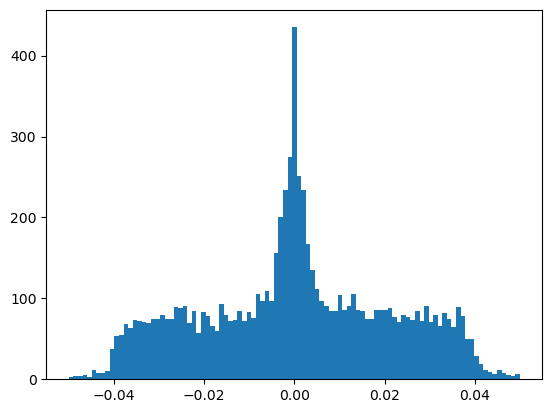

Epoch 21
-------------------------------
0.3385060429573059
loss: 1.388647  [60000/60000]
Test Error: 
 Accuracy: 66.8%, Avg loss: 1.513528 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.42311736941337585'
Epoch 22
-------------------------------
0.3363804519176483
loss: 1.347893  [60000/60000]
Test Error: 
 Accuracy: 68.2%, Avg loss: 1.472743 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4216768443584442'
Epoch 23
-------------------------------
0.33442237973213196
loss: 1.309089  [60000/60000]
Test Error: 
 Accuracy: 69.3%, Avg loss: 1.433967 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.42028021812438965'
Epoch 24
-------------------------------
0.3319486975669861
loss: 1.272250  [60000/60000]
Test Error: 
 Accuracy: 70.3%, Avg loss: 1.397208 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.41898787021636963'
Epoch 25
-------------------------------
0.33072343468666077
loss: 1.237338  [60000/60000]
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.362455 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.41769927740097046'
Epoc

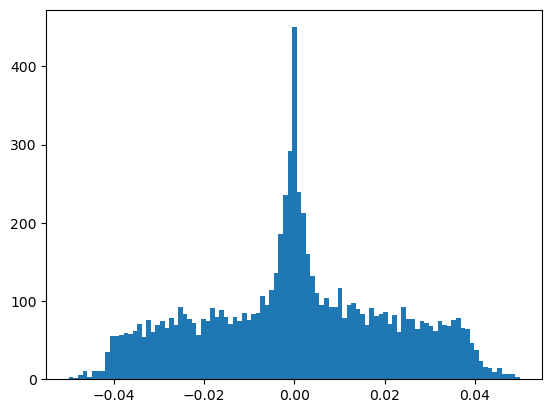

Epoch 31
-------------------------------
0.32309356331825256
loss: 1.066483  [60000/60000]
Test Error: 
 Accuracy: 76.1%, Avg loss: 1.192249 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.41009289026260376'
Epoch 32
-------------------------------
0.3220243453979492
loss: 1.043790  [60000/60000]
Test Error: 
 Accuracy: 76.7%, Avg loss: 1.169540 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4088364541530609'
Epoch 33
-------------------------------
0.3207957446575165
loss: 1.022515  [60000/60000]
Test Error: 
 Accuracy: 77.3%, Avg loss: 1.148185 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4075908362865448'
Epoch 34
-------------------------------
0.31972572207450867
loss: 1.002543  [60000/60000]
Test Error: 
 Accuracy: 77.9%, Avg loss: 1.128096 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4063435196876526'
Epoch 35
-------------------------------
0.3183337152004242
loss: 0.983789  [60000/60000]
Test Error: 
 Accuracy: 78.2%, Avg loss: 1.109171 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.4051436483860016'
Epoch 3

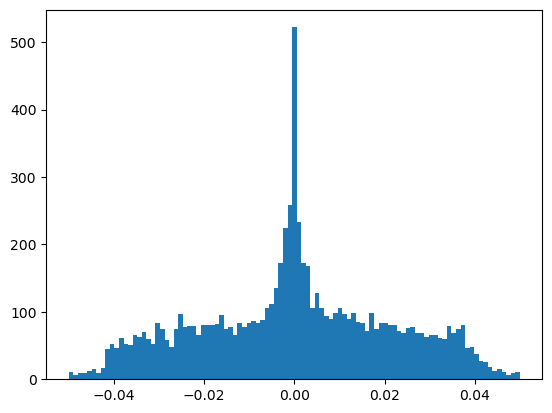

Epoch 41
-------------------------------
0.3118041157722473
loss: 0.891649  [60000/60000]
Test Error: 
 Accuracy: 80.3%, Avg loss: 1.015705 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3985353410243988'
Epoch 42
-------------------------------
0.31081876158714294
0.31095561385154724
loss: 0.879025  [60000/60000]
Test Error: 
 Accuracy: 80.7%, Avg loss: 1.002814 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3974708318710327'
Epoch 43
-------------------------------
0.30986925959587097
loss: 0.867038  [60000/60000]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.990530 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.39645177125930786'
Epoch 44
-------------------------------
0.30893072485923767
loss: 0.855629  [60000/60000]
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.978833 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3954424262046814'
Epoch 45
-------------------------------
0.30799737572669983
loss: 0.844763  [60000/60000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.967669 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.394

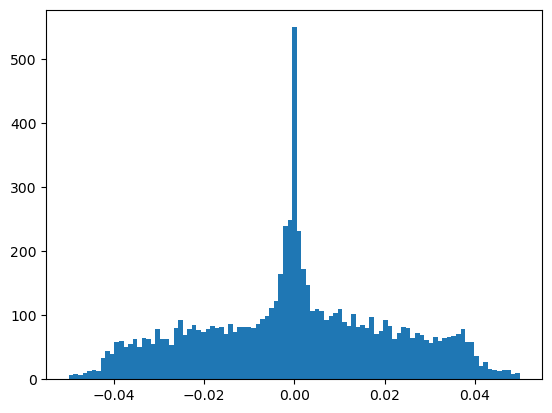

Epoch 51
-------------------------------
0.3025888502597809
loss: 0.789178  [60000/60000]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.910202 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.38878247141838074'
Epoch 52
-------------------------------
0.3017128109931946
loss: 0.781267  [60000/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.901964 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.38789719343185425'
Epoch 53
-------------------------------
0.3008820116519928
loss: 0.773682  [60000/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.894051 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.38702577352523804'
Epoch 54
-------------------------------
0.30004218220710754
0.3000606298446655
loss: 0.766405  [60000/60000]
Test Error: 
 Accuracy: 82.9%, Avg loss: 0.886442 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3861689865589142'
Epoch 55
-------------------------------
0.29923707246780396
0.2992779016494751
loss: 0.759418  [60000/60000]
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.879112 

'L0 Sparsity : 0.0%'
'P

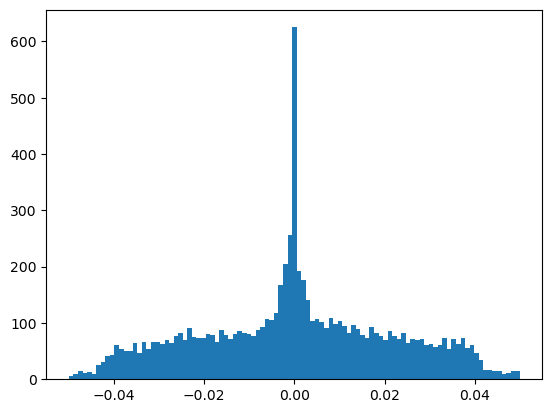

Epoch 61
-------------------------------
0.29454338550567627
0.29457008838653564
loss: 0.722702  [60000/60000]
Test Error: 
 Accuracy: 83.6%, Avg loss: 0.840230 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3804819583892822'
Epoch 62
-------------------------------
0.2937813401222229
0.29379183053970337
loss: 0.717321  [60000/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.834468 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3797215521335602'
Epoch 63
-------------------------------
0.29306432604789734
loss: 0.712119  [60000/60000]
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.828888 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3789710998535156'
Epoch 64
-------------------------------
0.2923339307308197
0.29234424233436584
loss: 0.707086  [60000/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.823475 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.37823042273521423'
Epoch 65
-------------------------------
0.29162147641181946
0.2916359603404999
loss: 0.702215  [60000/60000]
Test Error: 
 Accuracy: 83.9%, Avg 

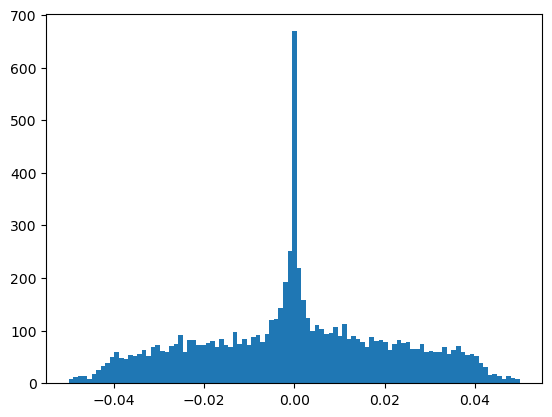

Epoch 71
-------------------------------
0.2875610888004303
0.2875698208808899
loss: 0.675938  [60000/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.789640 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.37335047125816345'
Epoch 72
-------------------------------
0.28691262006759644
0.28692111372947693
loss: 0.671987  [60000/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.785306 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.37268996238708496'
Epoch 73
-------------------------------
0.28627294301986694
0.28627949953079224
loss: 0.668144  [60000/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.781081 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.37203967571258545'
Epoch 74
-------------------------------
0.2856396436691284
0.2856396436691284
0.28564491868019104
0.2856508493423462
loss: 0.664403  [60000/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.776959 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.37139272689819336'
Epoch 75
-------------------------------
0.28501036763191223
0.2850135564804077
0.285

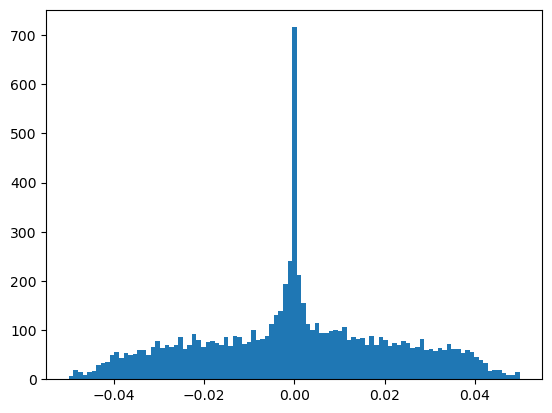

Epoch 81
-------------------------------
0.28136372566223145
0.281369149684906
0.28137272596359253
loss: 0.640741  [60000/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.750662 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3670574128627777'
Epoch 82
-------------------------------
0.28077998757362366
0.2807810306549072
0.28078505396842957
loss: 0.637678  [60000/60000]
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.747235 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.36646902561187744'
Epoch 83
-------------------------------
0.2802043855190277
0.2802044153213501
0.28020498156547546
0.28020790219306946
0.2802101969718933
0.28021180629730225
loss: 0.634686  [60000/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.743881 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.36588457226753235'
Epoch 84
-------------------------------
0.2796322703361511
0.2796322703361511
0.27963224053382874
0.27963224053382874
0.2796322703361511
0.27963387966156006
0.2796374261379242
0.27964362502098083
loss: 0.631762  [60000/60000]


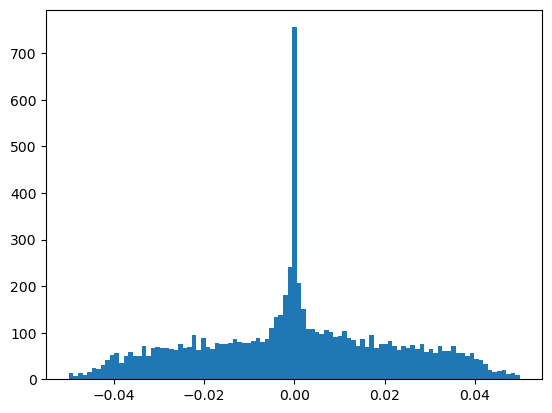

Epoch 91
-------------------------------
0.2757454812526703
0.2757454812526703
0.2757459580898285
0.27574604749679565
0.27574604749679565
0.2757488191127777
0.2757530212402344
loss: 0.612983  [60000/60000]
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.719369 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.3613838255405426'
Epoch 92
-------------------------------
0.27520766854286194
0.2752076983451843
0.2752077281475067
0.2752077281475067
0.27520933747291565
0.2752096354961395
0.275209903717041
0.27521011233329773
0.27521106600761414
0.27521130442619324
0.27521154284477234
0.2752118706703186
0.2752120792865753
0.2752120792865753
0.27521222829818726
0.27521222829818726
0.27521276473999023
0.2752133011817932
0.27521416544914246
loss: 0.610517  [60000/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.716566 

'L0 Sparsity : 0.0%'
'PQ Sparsity : 0.36084499955177307'
Epoch 93
-------------------------------
0.2746773362159729
0.2746773362159729
0.2746773660182953
0.27467766404151917
0.2746776640415191

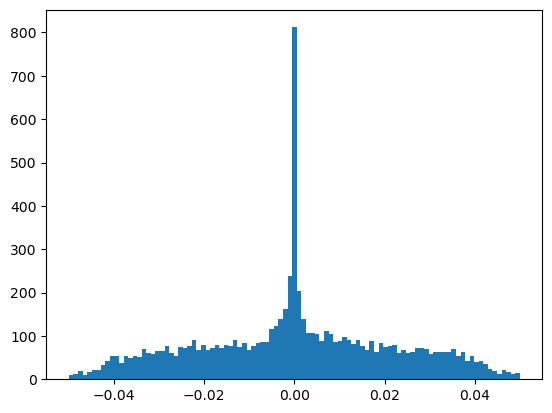

In [5]:
model = Linear(
    data_shape = (28, 28, ), 
    target_size = 10
    ).to(device)

# model = MLP(
#     data_shape=(28, 28), 
#     hidden_size=256, 
#     scale_factor=1, 
#     num_layers=3, 
#     activation="relu", 
#     target_size=10
# ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model.parameters(),     
    lr=1e-3,                
    momentum=0.9
)


l1 = 0.
l2 = 0. 
pqi=1e2

train_losses = []
test_losses = [] 
test_accuracy = []
PQIs = []



epochs = 100
for t in range(epochs): 
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_dict = train(train_dataloader, model, loss_fn, optimizer, device, l1=l1, l2=l2, pqi=pqi)
    test_dict = test(test_dataloader, model, loss_fn, device, l1=l1, l2=l2, pqi=pqi)
    
    train_losses.append(train_dict["loss"])
    test_losses.append(test_dict["loss"])
    test_accuracy.append(test_dict["accuracy"])
    pqi = PQI(model, device, 1, 2).item()
    PQIs.append(pqi)
    
    pprint(f"L0 Sparsity : {100 * L0_sparsity(model)}%")
    pprint(f"PQ Sparsity : {pqi}")
    
    if t in [0, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]: 
        parameterDistribution(model)

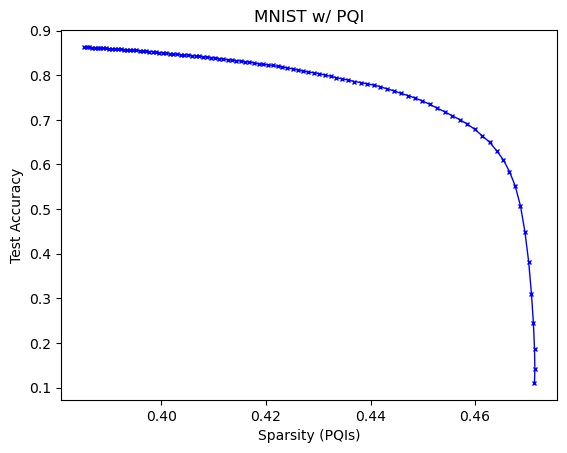

In [13]:
plt.plot(PQIs, test_accuracy, marker='x', color='b', markersize=3, linewidth=1)
plt.xlabel("Sparsity (PQIs)")
plt.ylabel("Test Accuracy")
plt.title("MNIST w/ PQI")
plt.show() 